In [36]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyradise as prs

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [6]:
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency

<IPython.core.display.Javascript object>


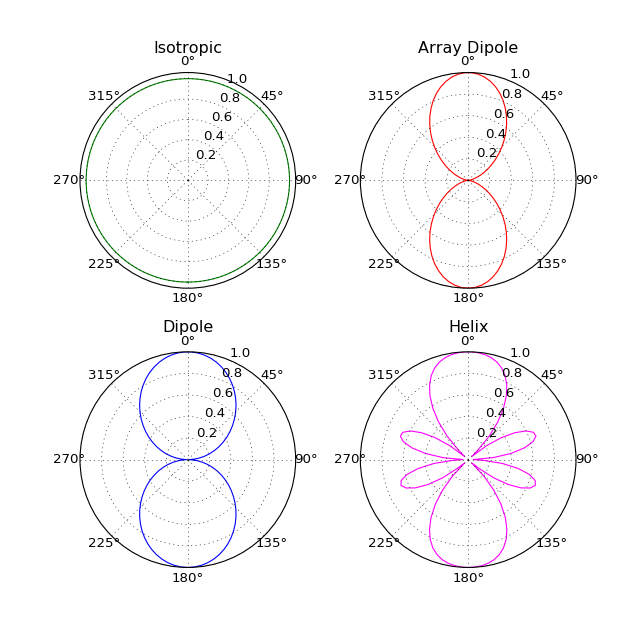

In [7]:
#
# Plotting radiation pattern of different antennas
#
theta = np.linspace(-pi, pi, num=100)
r1 = [prs.isotropic_rp(azimuth=t) for t in theta]
r2 = [prs.dipole_rp(azimuth=t) for t in theta]
r3 = [prs.array_dipole_rp(azimuth=t, n=2) for t in theta]
r4 = [prs.helix_rp(azimuth=t, n=3) for t in theta]

figure(1, figsize=(8,8))
ax1 = subplot2grid((2,2), (0,0), projection='polar')
ax2 = subplot2grid((2,2), (1,0), projection='polar')
ax3 = subplot2grid((2,2), (0,1), projection='polar')
ax4 = subplot2grid((2,2), (1,1), projection='polar')

ax1.plot(theta, r1, color='green', linewidth=1)
ax2.plot(theta, r2, color='blue', linewidth=1)
ax3.plot(theta, r3, color='red', linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')

ax1.set_title("Isotropic", va='bottom')
ax2.set_title("Dipole", va='bottom')
ax3.set_title("Array Dipole", va='bottom')
ax4.set_title("Helix", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

# ax.set_rscale('log')
# ax.set_rmax(0.008)
# ax.grid(True)

<IPython.core.display.Javascript object>


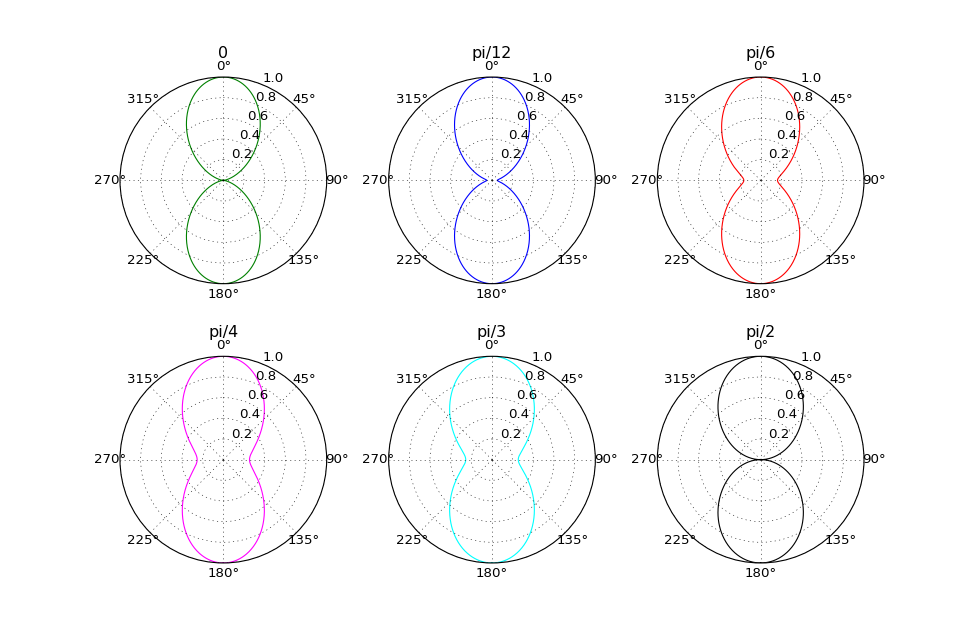

In [26]:
theta = np.linspace(-pi, pi, num=1000)

def log_rp(theta, phi, rp): 
    value = w2db(rp(theta, phi)) + 40
    if (value < 0):
        return 0
    else:
        return value

r1 = [prs.patch_rp(azimuth=t, tilt=0.001, wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]
r2 = [prs.patch_rp(azimuth=t, tilt=pi/12, wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]
r3 = [prs.patch_rp(azimuth=t, tilt=pi/6,  wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]
r4 = [prs.patch_rp(azimuth=t, tilt=pi/4,  wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]
r5 = [prs.patch_rp(azimuth=t, tilt=pi/3,  wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]
r6 = [prs.patch_rp(azimuth=t, tilt=pi/2,  wavelen=wave_length, width=wave_length/2, length=wave_length/2) for t in theta]

# r1 = prs.patch_rp(azimuth=theta, tilt=0.001, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r2 = prs.patch_rp(azimuth=theta, tilt=pi/12, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r3 = prs.patch_rp(azimuth=theta, tilt=pi/6,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r4 = prs.patch_rp(azimuth=theta, tilt=pi/4,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r5 = prs.patch_rp(azimuth=theta, tilt=pi/3,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r6 = prs.patch_rp(azimuth=theta, tilt=pi/2,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)

figure(2, figsize=(12,8))
ax1 = subplot2grid((2,3), (0,0), projection='polar')
ax2 = subplot2grid((2,3), (0,1), projection='polar')
ax3 = subplot2grid((2,3), (0,2), projection='polar')
ax4 = subplot2grid((2,3), (1,0), projection='polar')
ax5 = subplot2grid((2,3), (1,1), projection='polar')
ax6 = subplot2grid((2,3), (1,2), projection='polar')

ax1.plot(theta, r1, color='green',   linewidth=1)
ax2.plot(theta, r2, color='blue',    linewidth=1)
ax3.plot(theta, r3, color='red',     linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)
ax5.plot(theta, r5, color='cyan',    linewidth=1)
ax6.plot(theta, r6, color='black',   linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')
ax5.set_theta_zero_location('N')
ax6.set_theta_zero_location('N')

ax1.set_title("0", va='bottom')
ax2.set_title("pi/12", va='bottom')
ax3.set_title("pi/6", va='bottom')
ax4.set_title("pi/4", va='bottom')
ax5.set_title("pi/3", va='bottom')
ax6.set_title("pi/2", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)
ax5.set_theta_direction(-1)
ax6.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


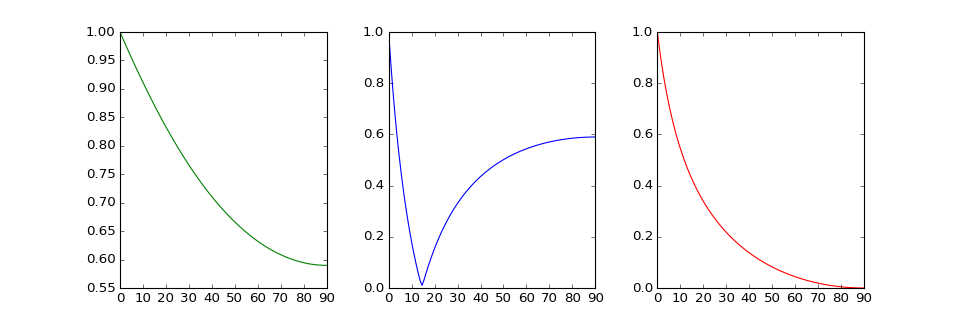

In [20]:
phi = np.linspace(0.0, pi/2, num=100)

r_pl = [np.absolute(prs.reflection(grazing_angle=t, polarization=1, permittivity=15, conductivity=0.03, wavelen=wave_length))
        for t in phi]
r_pp = [np.absolute(prs.reflection(grazing_angle=t, polarization=0, permittivity=15, conductivity=0.03, wavelen=wave_length))
        for t in phi]
# r_c  = [np.absolute(prs.reflection(grazing_angle=t, polarization=0.5, permittivity=15, conductivity=0.03, wavelen=wave_length))
#         for t in phi]

r_c  = np.absolute(prs.reflection(grazing_angle=phi, polarization=0.5, permittivity=15, conductivity=0.03, wavelen=wave_length))

figure(3, figsize=(12,4))
ax1 = subplot2grid((1,3), (0,0))
ax2 = subplot2grid((1,3), (0,1))
ax3 = subplot2grid((1,3), (0,2))

ax1.plot(phi*180/pi, r_pl, color='green', linewidth=1)
ax2.plot(phi*180/pi, r_pp, color='blue', linewidth=1)
ax3.plot(phi*180/pi, r_c, color='red', linewidth=1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

In [31]:
#
# Definining reader, tag and wireless transmission, or environment, parameters.
#

# environment parameters
# ground_reflection_r2t = lambda alpha: prs.reflection(grazing_angle=alpha, polaziration=0.5, permittivity=15, conductivity=0.03, wavelen=wave_length)
# ground_reflection_t2r = lambda alpha: prs.reflection(grazing_angle=alpha, polaziration=1, permittivity=15, conductivity=0.03, wavelen=wave_length)
thermal_noise = -116 #dBm

# reader paramters
reader_height = 5.0 #m
reader_angle  = pi/3
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 8 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 
# reader_rp = lambda alpha: prs.patch_rp(azimuth=alpha-reader_angle, tilt=0.00001, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

# tag parameters 
tag_speed = 20 #mps
tag_height = 0.5 #m
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
tag_sensitivity=-18.5 #dBm
tag_rp = lambda alpha: prs.dipole_rp(azimuth=alpha-tag_angle)

# mutual parameters
polarization_loss = -6.0 #dB
ceil_height = 6

<IPython.core.display.Javascript object>


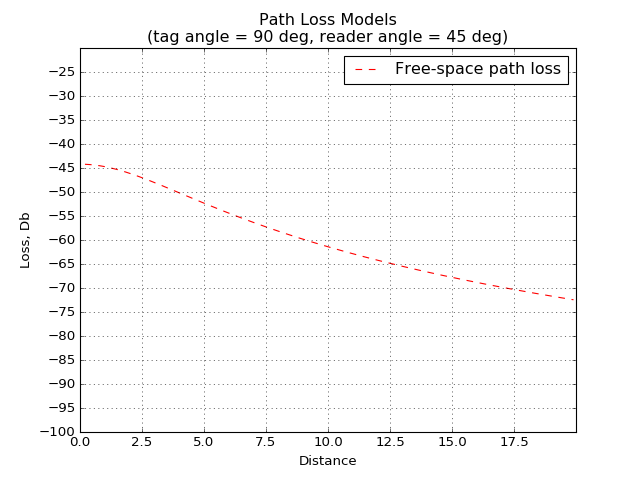

In [41]:
dist = arange(0.2, 20, 0.1)
pathloss = [prs.lin2db(prs.free_space_path_loss_2d(
            distance=d, tx_rp=prs.patch_rp, rx_rp=prs.dipole_rp, tx_height=reader_height, rx_height=tag_height, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)) for d in dist]

fig = figure(4)
ax = subplot(111)
plot(d, pathloss, 'r--', label='Free-space path loss')

# plot(d, w2db(R3PL_Doppler(d, 0.3, ground_reflection_t2r, 20)) , 'c',   label='Doppler')
# plot(d, w2db(R3PL_Doppler(d, 0.3, ground_reflection_t2r, 40)) , 'b',   label='Doppler')

grid(True)
ax.set_ybound(lower=-100, upper=-20)
ax.set_xticks(arange(0, 20, 2.5))
ax.set_yticks(arange(-100, -20, 5))
ax.set_xlabel("Distance")
ax.set_ylabel("Loss, Db")
ax.set_title('Path Loss Models\n(tag angle = 90 deg, reader angle = 45 deg)')
legend()